In [1]:
import numpy as np 
import pandas as pd 
from glob import glob
import ast
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
from ast import literal_eval
import os
import pickle
import cv2
import time
import random 
import itertools

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve

# Doodle Drawings Recognition

## Author: Svetlana Topalova

### Abstract

In this project we will take a small subset of Doodle drawing images from 10 catagories. We will try to train a model which recognizes them. We will perform tuning on the classifier in order to score better results. And finally we will measure the model performance.


### Overview

"Quick, Draw!" was released as an experimental game to educate the public in a playful way about how AI works. The game prompts users to draw an image depicting a certain category, such as ”banana,” “table,” etc. The game generated more than 1B drawings, of which a subset was publicly released as the basis for this competition’s training set. That subset contains 50M drawings encompassing 340 label categories.

<img src="files/what-does-a-bee-look-like-1.png" width="400">

### Data exploration

The data we use is taken from https://www.kaggle.com/c/quickdraw-doodle-recognition/data

**Attributes and their explanation**: 
1. key_id: Just a ID to identify each image. 
1. countrycode: two letter country code. More: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2 
1. drawing: vectors of the doodle.
1. recognized: Whether the word was recognized by the game. If it is not recongnized by the game we can still use this labelled data for training the model.
1. time-stamp: Time 
1. word: the response class

[ 
[  // First stroke 
[x0, x1, x2, x3, ...],
[y0, y1, y2, y3, ...],
[t0, t1, t2, t3, ...]
],
[  // Second stroke
[x0, x1, x2, x3, ...],
[y0, y1, y2, y3, ...],
[t0, t1, t2, t3, ...]
],
... // Additional strokes
]

Where x and y are the pixel coordinates, and t is the time in milliseconds since the first point. x and y are real-valued while t is an integer. The raw drawings can have vastly different bounding boxes and number of points due to the different devices used for display and input. 
In simplified data time was removed. 

**We will used the simplified data which is divided into csv files by class.**

#### Read data

We will use 2500 samples per category for 10 random categories.

In [3]:
class_files = os.listdir("input")
classes = {x[:-4]:i for i, x in enumerate(class_files)}
to_class = {i:x[:-4].replace(" ", "_") for i, x in enumerate(class_files)}

In [5]:
BATCHSIZE = 2500

In [6]:
categories = random.sample(class_files, 10)
print(categories)

['suitcase.csv', 'dumbbell.csv', 'leg.csv', 'firetruck.csv', 'stove.csv', 'mouth.csv', 'shark.csv', 'potato.csv', 'penguin.csv', 'streetlight.csv']


In [7]:
drawings_dfs = [pd.read_csv("input/" + x, nrows=BATCHSIZE)[["word", 'recognized', "drawing"]] for x in categories]

In [8]:
drawings_df = pd.concat(drawings_dfs)

In [9]:
def strokes_to_img(in_strokes, image_size = (48, 48)):
    in_strokes = eval(in_strokes)
    # make an agg figure
    fig, ax = plt.subplots()
    for x,y in in_strokes:
        ax.plot(x, y, linewidth=7.) 
    ax.axis('off')
    ax.axis('equal')
    #ax.invert_yaxis()
    fig.canvas.draw()
    
    # grab the pixel buffer and dump it into a numpy array
    X = np.array(fig.canvas.renderer._renderer)
    plt.close(fig)
    return (cv2.resize(X, image_size) / 255.)[::-1]

Let's see how the drawings look like.

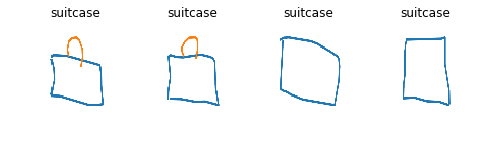

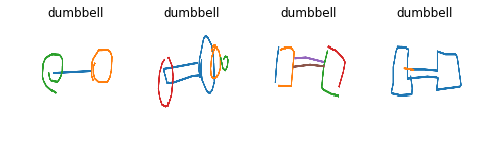

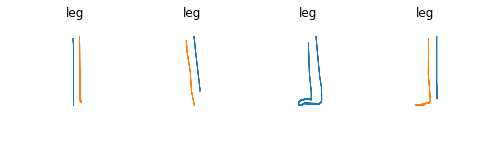

In [55]:
for j in range(3):
    plt.figure(figsize=(8,8))
    for i in range(4):
        plt.subplot(1,4,i+1)
        drawing_data = drawings_df.iloc[j*BATCHSIZE+i]
        drawing = strokes_to_img(drawing_data.drawing, image_size = (96,96))
        plt.imshow(drawing)
        plt.title(drawing_data.word)
        plt.axis('off')
        #plt.gca().invert_yaxis()
        #plt.axis('equal');
    plt.show()

### Data Analysis

Let's see the hardest (the least recognizable) drawing categories:

In [60]:
recognized_drawings = drawings_df.groupby('word')["recognized"].count().reset_index(name='count').sort_values(['count'])

recognized_drawings

,word,count
7,stove,2046
0,dumbbell,2125
1,firetruck,2259
4,penguin,2281
5,potato,2333
3,mouth,2337
6,shark,2365
2,leg,2375
9,suitcase,2386
8,streetlight,2392


### Data Cleaning 

In order to train the model with the best data we will remove unrecognized images. 

In [12]:
drawings_df = drawings_df[drawings_df.recognized == True]
print(drawings_df.shape)

(22899, 3)


### Data Preprocessing 

We need more effecient method to read the images so we will convert them to black and white image. This way each image will have only one channel instead of 3 channels (RGB). Also we don't need shades so we will normalize the image into binary one.

In [13]:
IMAGE_BASE_SIZE = 256
IMAGE_SIZE = 48 

In [14]:
def convert_to_black_and_white(image):
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue = image[:, :, 2]
    image_grayscale = np.mean([red, green, blue], axis=0)
    image_grayscale[image_grayscale >= 1.] = 1
    image_grayscale[image_grayscale < 1.] = 0
    return image_grayscale.astype(np.uint8)

def strokes_to_black_and_white_img(in_strokes):
    image = strokes_to_img(in_strokes)
    return convert_to_black_and_white(image)
    
def df_to_image_array(df):
    out_imgs = list(map(strokes_to_black_and_white_img, df["drawing"]))
    X = np.array(out_imgs)
    return X

In [15]:
labels = np.asarray(drawings_df.word)
print(labels.shape)
print(np.unique(labels))

(22899,)
['dumbbell' 'firetruck' 'leg' 'mouth' 'penguin' 'potato' 'shark' 'stove'
 'streetlight' 'suitcase']


In [16]:
X = df_to_image_array(drawings_df)
print(X.shape[0])

22899


In [17]:
X_ravel = np.asarray([x.ravel() for x in X])

In [18]:
X_ravel.shape

(22899, 2304)

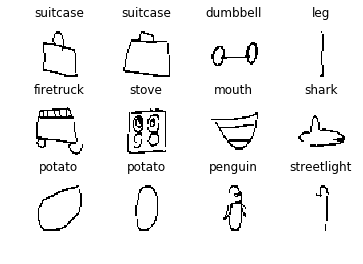

In [19]:
for i in range(12):
    plt.subplot(3,4,i+1)
    image = X[i*2000]
    plt.imshow(image,  cmap='gray')
    plt.title(labels[i*2000])
    plt.axis('off')
plt.show()

### Data splitting

We will split the data into training - 60%, validation - 10% and testing - 30%. Our data is not shuffled so we need to set the parameter stratify to the data labels.

In [21]:
labels.shape

(22899,)

In [22]:
x, x_test, y, y_test = train_test_split(X_ravel,labels,test_size=0.3,train_size=0.7, stratify=labels)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.15,train_size =0.85, stratify=y)

In [23]:
print(X_ravel.shape,x_train.shape, x_test.shape, x_cv.shape)

(22899, 2304) (13624, 2304) (6870, 2304) (2405, 2304)


### PCA

PCA is **the simplest of the true eigenvector-based multivariate analyses**. Often, its operation can be thought of as **revealing the internal structure of the data in a way that best explains the variance** in the data. If a multivariate dataset is visualised as a set of coordinates in a high-dimensional data space (1 axis per variable), PCA can supply the user with a lower-dimensional picture, a projection of this object when viewed from its most informative viewpoint. This is done by **using only the first few principal components** so that the **dimensionality** of the transformed data is **reduced**.

In [24]:
pca = PCA(.95)
pca.fit(x_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
pca.explained_variance_ratio_.shape

(768,)

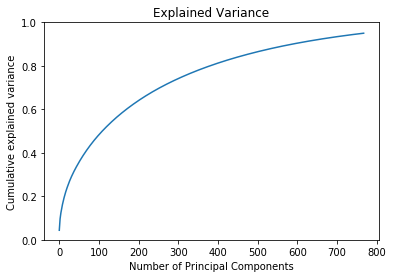

In [26]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)

ax1.plot(np.cumsum(pca.explained_variance_ratio_))

ax1.set_ylim([0,1.0])

ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative explained variance')
ax1.set_title('Explained Variance')

plt.show()

In [27]:
x_train_transform = pca.transform(x_train)

In [28]:
x_train_transform.shape

(13624, 768)

### Search for the best classifier

We will try a few classifiers just to pick some of them for additional tuning. 

In [30]:
classifiers = [
    LogisticRegression(solver = 'lbfgs'),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    QuadraticDiscriminantAnalysis(),
    AdaBoostClassifier(n_estimators=10),
    LinearSVC(),
    SVC()
]


x_cv_transform = pca.transform(x_cv)
for clf in classifiers:
    print(clf)
    fit_start = time.time()
    clf.fit(x_train_transform, y_train)
    fit_end = time.time()
    print("Learning time:", str(round(fit_end - fit_start, 2))+"sec")
    score_start = time.time()
    score = clf.score(x_cv_transform, y_cv)
    score_end = time.time()
    print("Scoring time:", str(round(score_end - score_start, 2))+"sec")
    print("Model score:",score)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)
Learning time: 8.13sec
Scoring time: 0.01sec
Model score: 0.7825363825363826
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Learning time: 0.87sec
Scoring time: 49.29sec
Model score: 0.5322245322245323
GaussianNB(priors=None)
Learning time: 0.28sec
Scoring time: 0.32sec
Model score: 0.6806652806652806
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None

### Tuning the model

In scikit-learn 'C' parameter is inverse of lambda. 
1. Increasing C ⇒ weaker regularization
    The algorithm follows the data more closely
1. Decreasing C ⇒ stronger regularization
    The algorithm "doesn't care too much about the data"
    
Regularization types
1. L2 regularization - Shrinks all model weights by the same value
1. L1 regularization – Sets some coefficients to 0: feature selection

For Gaussian SVM classifier we are increasing C parameter in order to follow the data more closely.

The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples. 

The multiclass support is handled according to a one-vs-one scheme.

In [31]:
svc_classifier = SVC(C=2)
svc_classifier.fit(x_train_transform, y_train)

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [32]:
print("SVC; score:", svc_classifier.score(x_cv_transform, y_cv))

SVC; score: 0.8636174636174636


Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

In [33]:
linear_svc_classifier = LinearSVC(C=2)
linear_svc_classifier.fit(x_train_transform, y_train)

LinearSVC(C=2, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [34]:
print("linear_svc_classifier; score:", linear_svc_classifier.score(x_cv_transform, y_cv))

linear_svc_classifier; score: 0.7592515592515593


**Grid Search with Cross Validation**

We will use cross-validation to train and optimize the hyperparameters some of the classifiers.

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. 

**RandomForestClassifier**

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [35]:
grid_search_params = {"n_estimators": [50, 100],#20,30,40
                 "max_depth": [300]} #100, 200
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = grid_search_params, cv=3)
grid_search.fit(x_train_transform, y_train)

forest_classifier = grid_search.best_estimator_

print("Random forest; best score:", grid_search.best_score_)

Random forest; best score: 0.7860393423370523


In [36]:
print("Random forest; best params:", grid_search.best_params_)

Random forest; best params: {'max_depth': 300, 'n_estimators': 100}


**LogisticRegression**

In the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the ‘multi_class’ option is set to ‘ovr’, and uses the cross- entropy loss if the ‘multi_class’ option is set to ‘multinomial’

In [37]:
tuned_params = [{"C": [0.001, 0.01, 1, 10], 
                 "max_iter": [10, 20, 30, 50, 100], 
                 "fit_intercept": [True, False]
                }]
grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'), tuned_params)
grid_search.fit(x_train_transform, y_train)

logisticRegression_classifier = grid_search.best_estimator_

print("LogisticRegression; best score:", grid_search.best_score_)

LogisticRegression; best score: 0.8138578978273635


In [38]:
grid_search.best_params_

{'C': 0.01, 'fit_intercept': True, 'max_iter': 20}

### Measuring Model Performance

Now we will score the models:

Estimator score method: Estimators have a score method providing a default evaluation criterion for the problem they are designed to solve. 

In [39]:
x_test_transform = pca.transform(x_test)

In [40]:
forest_classifier_score = forest_classifier.score(x_test_transform, y_test)
print("RandomForestClassifier accuracy score", forest_classifier_score)

RandomForestClassifier accuracy score 0.8059679767103348


In [41]:
forest_classifier_y_pred = forest_classifier.predict(x_test_transform)
print("RandomForestClassifier F1 score", f1_score(y_test, forest_classifier_y_pred, average = "micro"))

RandomForestClassifier F1 score 0.8059679767103347


In [42]:
logisticRegression_classifier_score = logisticRegression_classifier.score(x_test_transform, y_test)
print("LogisticRegression accuracy score", logisticRegression_classifier_score)

LogisticRegression accuracy score 0.8161572052401747


In [43]:
logisticRegression_classifier_y_pred = logisticRegression_classifier.predict(x_test_transform)
print("LogisticRegression F1 score", f1_score(y_test, logisticRegression_classifier_y_pred, average = "micro"))

LogisticRegression F1 score 0.8161572052401747


In [44]:
svc_classifier_score = svc_classifier.score(x_test_transform, y_test)
print("Gaussian SVM accuracy score", svc_classifier_score)

Gaussian SVM accuracy score 0.8576419213973799


In [45]:
svc_classifier_y_pred = svc_classifier.predict(x_test_transform)
print("Gaussian SVM F1 score", f1_score(y_test, svc_classifier_y_pred, average = "micro"))

Gaussian SVM F1 score 0.8576419213973799


In [46]:
# https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

Gaussian SVM Confusion matrix

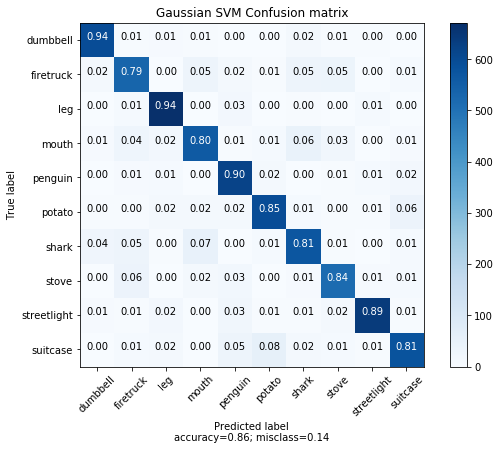

In [47]:
cnf_matrix = confusion_matrix(y_test, svc_classifier_y_pred)
plot_confusion_matrix(cnf_matrix, svc_classifier.classes_, title ="Gaussian SVM Confusion matrix", normalize=True)

LogisticRegression Confusion matrix

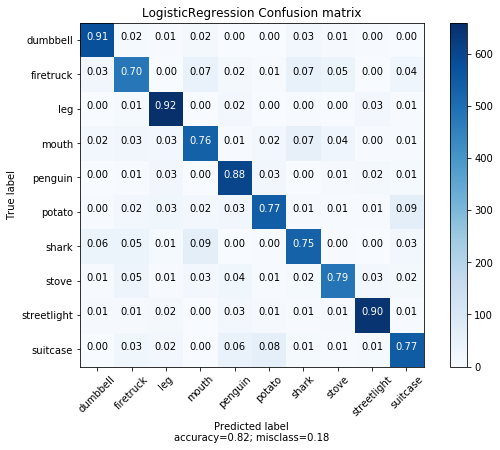

In [48]:
cnf_matrix = confusion_matrix(y_test, logisticRegression_classifier_y_pred)
plot_confusion_matrix(cnf_matrix, logisticRegression_classifier.classes_, title ="LogisticRegression Confusion matrix", normalize=True)

In [49]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

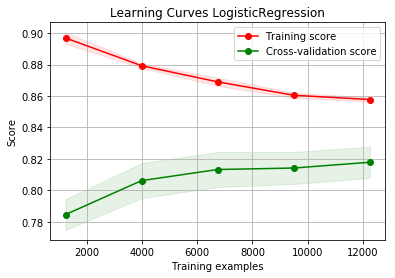

In [50]:
title = "Learning Curves LogisticRegression"
plot_learning_curve(logisticRegression_classifier, title, x_train_transform, y_train, cv=10, n_jobs=5)
plt.show()

Obviously, the gap between the two curves is large, which indicates high variance (overfitting). Possible solutions are removing model features (preprocessing improvement /feature selection /feature engineering, etc.), increase regularization (decreasing C).

### Predictions

Few examples of the trained LogisticRegression model's predictions on the test data. For each drawing are shown top 3 predicted categories ordered by probability estimates.

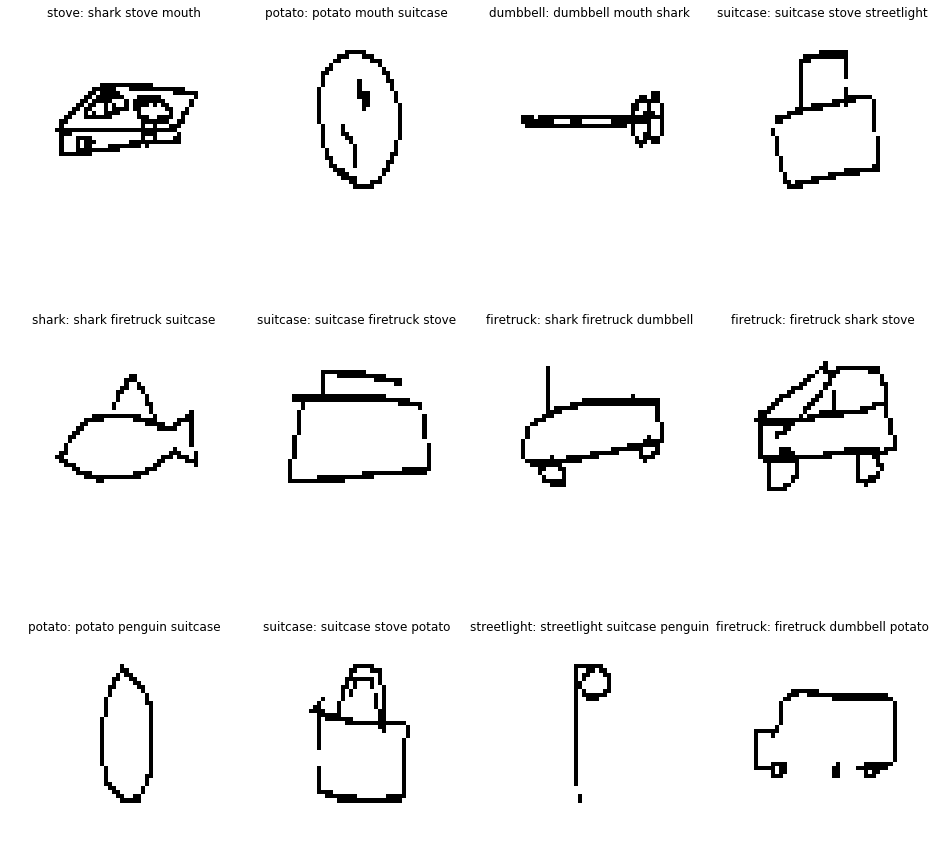

In [53]:
predict_proba = logisticRegression_classifier.predict_proba(x_test_transform[0:12])
y = []
i = 0
plt.figure(figsize=(16,16))
for index, prob in enumerate(predict_proba):
    plt.subplot(3,4,index+1)
    image = x_test[index].reshape((IMAGE_SIZE, IMAGE_SIZE))
    max_prob = logisticRegression_classifier.classes_[prob.argsort()[-3:][::-1]]
    y_str = ' '.join(str(x).replace(" ", "_") for x in max_prob)
    #print()
    plt.imshow(image,  cmap='gray')
    plt.title(str(y_test[index] + ": " + y_str))
    plt.axis('off')
    y.append(y_str)
    i += 1
plt.show()

### Conclusion

We took a small part of the Doodle dataset to experiment with training a model for recognizing them. A normalization was applied on the drawings by presenting them in binary images. PCA was used to reduce the dimension of the data. Different classifiers were tried on the validation data just to pick some of them for further tuning. The best models we trained were Logistic Regression and Gaussian SVM (support vector machine). They scored over 80% on the test data.

Future work will be simplifing the input data even more and training a neural network on more data.


### References

http://scikit-learn.org

https://www.kaggle.com/c/quickdraw-doodle-recognition/data

https://softuni.bg/trainings/1920/machine-learning-august-2018

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://charlesreid1.github.io/circe/Digit%20Classification%20-%20PCA.html

https://en.wikipedia.org/